# Jupyter Notebook to Processing Pipeline

To translate the notebook with a working machine learning model into a piece of software, I would first ensure that I have one version of the model for production and one for development. The model that is used in production will not be changed until a given time period for maintenance in which it may be swapped out for the development model that is being improved upon. This ensures that updates do not result in production issues since all updates will be applied to the development model first. For updating, I will need a training set, validation set, and test set. The training set will be used to train the model parameters, the validation set will be used to tune the model hyperparameters and the test set will be a final evaluation to see if the development model is feasible. For the production model, I would save the model parameters in a file (or in an external database) so that I could simply read and upload them into memory upon start up or reboot, this ensures that the production model will never be lost. In terms of processing, I need to ensure that all input images/video frames have the same input size to ensure that they generate similar sized outputs, thus there is a need to do some image processng before feeding the images or video frames into the model. In addition, I may also need to ensure that they have the same number of color channels and that they have been denoised. To speed up processing, I can rely on using the GPU for image convolutionss (CNNs) and I can also use multithreading to help with some sequential tasks if I have more than 1 CPU core. The most important speed up, would be to have different containers running the same model and then allocating each set of images/video frames to a different container to handle. This involves horizontal scaling with Kubernetes pods. I find this to be very efficient because, then we can have dedicated servers for handling a large volume of images for processing, in other words, we can just send a set of images to one of the pods and then have a few central servers in charge of handling the output responses and directing them to the senders of those image sets.   

# Demo

In this demo, I will be showcasing an example of a CNN (convolutional neural network) which is designed to categorize hand gestures. This model takes in a 224x224 pixel image of a hand gesture (of letters A-I (9 letters)) and it will categorize them appropiately. Keep in mind, these hand gestures refer to the American Sign Language. This model involves usiing spatial and pixel information through 2D convolution to extract features which will be able to tell us which of the 9 gestures that the hand signs belong to. After extracting the features, the feature information is then flattened and passed through a linear classifier which will provide estimates on which class is the most likely. The main point of the CNN is to perform the feature extraction correctly so that only the relevant features are used during the classification step. This model will be trained using a provided dataset.    

In [2]:
# Import all the modules I need

# I will need these modules for moving around some files
import os
from pathlib import Path
# I will need this module to test how long my function will take
import time
# I will use these modules to perform tensor/numpy operations
import numpy as np
import torch
# I will use these modules to implement the NN and for training
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# I will use these modules to help create my datasets
import torchvision
from torchvision import datasets, models, transforms
# This module is for plotting data
import matplotlib.pyplot as plt
# This module will help with calculations
import math

In [3]:
# First, I should define the class that I will be using to instantiate the CNN Model, this class will take in several variable parameters:
class CNN_Gestures(nn.Module):

  torch.manual_seed(1)
    
  # Pass in the dimensions of the input image as a tuple
  
  # Convolutional layers are written as a list of convolutional layer parameters(c_layers->list of tuples), 
  # this class iterates through the list and unpacks the parameters into Conv2d

  # Pooling layers are applied per convolutional layer, (p_layers->list of tuples), 
  # this class iterates through the list and unpacks the parameters into MaxPool2d

  # Note: Convolutional and Pooling layers are cascaded as follows: Conv2d-> Activation Function-> MaxPool2d
  # Size of c_layers and p_layers must be the same

  # Hidden units are given as a list, the first linear layer has the input computed from the number of features 
  # and then has l_layers[0] outputs, ... each layer thereafter has l_layer[i] inputs and l_layer[i+1] outputs
  # the final layer has output_size outputs
  
  # Activation function is passed in as an input, please use the activation functions specified in the nn Module

  # Output size is passed in as output_size

  def __init__(self, input_dim=(224, 224), c_layers=[(3, 5, 5),(5, 10, 5),(10,15,5)], p_layers=[(3,3),(3,3),(3,3)], activation_function=nn.ReLU, l_layers=[30], output_size=9):
        super(CNN_Gestures, self).__init__()
        # Store all of our layers/operations in structure
        structure = []
        num_conv = len(c_layers)
        num_lin = len(l_layers) + 1
        input_shape = input_dim
        # Iterate through c_layers and p_layers and store each layer
        for i in range(num_conv):
            # Create each convolutional layer as convolution->activation_function->pooling
            structure.extend([nn.Conv2d(*(c_layers[i])), activation_function(), nn.MaxPool2d(*(p_layers[i]))])
            # Compute the dimensions of the output map after each layer
            Hout, Wout, num_feature_maps = self.compute_convolution_output_size(input_shape, c_layers[i])
            Hout, Wout = self.compute_pooling_output_size([Hout, Wout], p_layers[i])
            input_shape = (Hout, Wout)

        # Make sure to flatten the output from the convolutional layers
        structure.append(nn.Flatten())
        # Generate the expected input size to the linear layers
        linear_input_size = Hout * Wout * num_feature_maps
        self.linear_input_size = linear_input_size
        # prepend and append l_layers with the input and output sizes
        linear_layers = [linear_input_size, *l_layers, output_size]
        for i in range(num_lin):
            # Create each linear layer and append it with the activation function as long as it's not the output layer
            structure.append(nn.Linear(linear_layers[i], linear_layers[i+1]))
            if i != (num_lin-1):
                structure.append(activation_function())
        # All layers are now stored and cascaded
        self.layers = nn.Sequential(*structure)
        self.name = "CNN_Gestures"

  def forward(self, img):
      # All operations are applied one after the other
      output = self.layers(img)
      return output

  # This function computes the resulting output size after a convolution is done on the input
  # It returns the number of feature maps and the height and width of those feature maps
  def compute_convolution_output_size(self, input_dim, c_params):
      Hin = input_dim[0]
      Win = input_dim[1]
      # Not all parameters will be used for each layer, so some will be skipped 
      c_params_list = ['Cin', 'Cout', 'K', 'S', 'P', 'D', 'G', 'B', 'PM']
      conv_dict = {}
      for i in range(1, len(c_params)):
          conv_dict[c_params_list[i]] = c_params[i]

      # Kernel size
      if isinstance(conv_dict['K'], int) == True:
          conv_dict['K'] = (conv_dict['K'], conv_dict['K'])

      # Stride size
      if 'S' not in conv_dict:
          conv_dict['S'] = (1,1)
      elif isinstance(conv_dict['S'], int) == True:
          conv_dict['S'] = (conv_dict['S'], conv_dict['S'])

      # Padding size
      if 'P' not in conv_dict:
          conv_dict['P'] = (0,0)
      elif isinstance(conv_dict['P'], int) == True:
          conv_dict['P'] = (conv_dict['P'], conv_dict['P'])

      # Dilation size
      if 'D' not in conv_dict:
          conv_dict['D'] = (1,1)
      elif isinstance(conv_dict['D'], int) == True:
          conv_dict['D'] = (conv_dict['D'], conv_dict['D'])
      
      # This computation can be found in the Pytorch documentation for Conv2d
      Hout = math.floor((Hin + 2 * conv_dict['P'][0] - conv_dict['D'][0] * (conv_dict['K'][0] - 1) - 1) / conv_dict['S'][0] + 1)
      Wout = math.floor((Win + 2 * conv_dict['P'][1] - conv_dict['D'][1] * (conv_dict['K'][1] - 1) - 1) / conv_dict['S'][1] + 1)

      return Hout, Wout, conv_dict['Cout']

  # This function computes the resulting output size after pooling is done on the input
  # It returns the height and width of the new feature maps
  def compute_pooling_output_size(self, input_dim, p_params):
      Hin = input_dim[0]
      Win = input_dim[1]

      # Not all parameters will be used for each layer, so some will be skipped 
      p_params_list = ['K', 'S', 'P', 'D', 'R']
      pooling_dict = {}
      for i in range(len(p_params)):
          pooling_dict[p_params_list[i]] = p_params[i]

      # Kernel size
      if isinstance(pooling_dict['K'], int) == True:
          pooling_dict['K'] = (pooling_dict['K'], pooling_dict['K'])

      # Stride size
      if 'S' not in pooling_dict:
          pooling_dict['S'] = (pooling_dict['K'],pooling_dict['K'])
      elif isinstance(pooling_dict['S'], int) == True:
          pooling_dict['S'] = (pooling_dict['S'],pooling_dict['S'])

      # Padding size
      if 'P' not in pooling_dict:
          pooling_dict['P'] = (0,0)
      elif isinstance(conv_dict['P'], int) == True:
          pooling_dict['P'] = (pooling_dict['P'], pooling_dict['P'])

      # Dilation size
      if 'D' not in pooling_dict:
          pooling_dict['D'] = (1,1)
      elif isinstance(conv_dict['D'], int) == True:
          pooling_dict['D'] = (pooling_dict['D'], pooling_dict['D'])

      # This computation can be found in the Pytorch documentation for MaxPool2d
      Hout = math.floor((Hin + 2 * pooling_dict['P'][0] - pooling_dict['D'][0] * (pooling_dict['K'][0] - 1) - 1) / pooling_dict['S'][0] + 1)
      Wout = math.floor((Win + 2 * pooling_dict['P'][1] - pooling_dict['D'][1] * (pooling_dict['K'][1] - 1) - 1) / pooling_dict['S'][1] + 1)

      return Hout, Wout

In [ ]:
# Mount my drive so that I can access the zip file
from google.colab import drive
drive.mount('/content/drive')

In [5]:
# Unzip all of the files into /root/datasets/
# Note that this directory may be different if run somewhere else, I am running this in my Google Drive
!unzip '/content/drive/MyDrive/Colab Notebooks/APS360/Lab3/Lab_3_Gesture_Dataset.zip' -d '/root/datasets'

Archive:  /content/drive/MyDrive/Colab Notebooks/APS360/Lab3/Lab_3_Gesture_Dataset.zip
   creating: /root/datasets/Lab_3b_Gesture_Dataset/A/
  inflating: /root/datasets/Lab_3b_Gesture_Dataset/A/1_A_1.jpg  
  inflating: /root/datasets/Lab_3b_Gesture_Dataset/A/1_A_2.jpg  
  inflating: /root/datasets/Lab_3b_Gesture_Dataset/A/1_A_3.jpg  
  inflating: /root/datasets/Lab_3b_Gesture_Dataset/A/10_A_1.jpg  
  inflating: /root/datasets/Lab_3b_Gesture_Dataset/A/10_A_2.jpg  
  inflating: /root/datasets/Lab_3b_Gesture_Dataset/A/10_A_3.jpg  
  inflating: /root/datasets/Lab_3b_Gesture_Dataset/A/100_A_1.jpg  
  inflating: /root/datasets/Lab_3b_Gesture_Dataset/A/100_A_2.jpg  
  inflating: /root/datasets/Lab_3b_Gesture_Dataset/A/100_A_3.jpg  
  inflating: /root/datasets/Lab_3b_Gesture_Dataset/A/101_A_1.jpg  
  inflating: /root/datasets/Lab_3b_Gesture_Dataset/A/101_A_2.jpg  
  inflating: /root/datasets/Lab_3b_Gesture_Dataset/A/101_A_3.jpg  
  inflating: /root/datasets/Lab_3b_Gesture_Dataset/A/102_A_1.jpg

In [6]:
# Set up a few dictionaries to help map relationships
# I will use them to divide up the dataset based on specific distributions
letters = os.listdir('/root/datasets/Lab_3b_Gesture_Dataset/')
# This is a list of files
file_list = []
# This will map classes to their corresponding files: letter_to_files["letter"] = list of files with class "letter"
letter_to_files = {}
# This will map files to their class: file_to_target["file_path"] = class
file_to_target = {}
# This will map hand ids to their corresponding files: file_to_target["id"] = list of files with specific hand id
id_to_files = {}

for i in letters:
    file_dir = os.path.join('/root/datasets/Lab_3b_Gesture_Dataset/',i)
    # Only take the files, ignore the sub directories
    letter_to_files[i] = [os.path.join(file_dir,f) for f in os.listdir(file_dir) if f.endswith('.jpg')]
    file_list.extend(letter_to_files[i])

for f in file_list:
    # The id and the class can be parsed from the file name: id_letter_orientation.jpg, but it's easier to store them in a dictionary 
    id = str(os.path.basename(f)).split('_')[0]
    target = str(os.path.basename(f)).split('_')[1]
    if id in id_to_files:
        id_to_files[id].append(f)
    else:
        id_to_files[id] = []
        id_to_files[id].append(f)
    file_to_target[f] = target
# Let's see the total number of files
print(f'Total number of samples: {len(file_list)}')

Total number of samples: 2431


In [7]:
# Let's see the distribution of the letters:
for i in letter_to_files:
    print(f'The letter {i} has {len(letter_to_files[i])} samples')

The letter I has 249 samples
The letter E has 272 samples
The letter B has 273 samples
The letter F has 273 samples
The letter D has 273 samples
The letter G has 273 samples
The letter A has 272 samples
The letter C has 273 samples
The letter H has 273 samples


In [8]:
# Let's see the distribution of hand ids:
for i in id_to_files:
    print(f'Unique hand #{i} has {len(id_to_files[i])} samples')

Unique hand #50 has 27 samples
Unique hand #6 has 27 samples
Unique hand #12 has 27 samples
Unique hand #66 has 27 samples
Unique hand #62 has 26 samples
Unique hand #81 has 27 samples
Unique hand #1 has 27 samples
Unique hand #57 has 27 samples
Unique hand #101 has 27 samples
Unique hand #90 has 27 samples
Unique hand #63 has 27 samples
Unique hand #87 has 27 samples
Unique hand #17 has 27 samples
Unique hand #38 has 27 samples
Unique hand #13 has 27 samples
Unique hand #54 has 27 samples
Unique hand #7 has 27 samples
Unique hand #42 has 27 samples
Unique hand #14 has 27 samples
Unique hand #3 has 27 samples
Unique hand #9 has 27 samples
Unique hand #18 has 27 samples
Unique hand #96 has 27 samples
Unique hand #55 has 27 samples
Unique hand #67 has 27 samples
Unique hand #73 has 27 samples
Unique hand #41 has 27 samples
Unique hand #76 has 27 samples
Unique hand #16 has 27 samples
Unique hand #74 has 27 samples
Unique hand #32 has 27 samples
Unique hand #78 has 27 samples
Unique hand 

In [9]:
# Create the test set
total = 0
test_set = []
for i in id_to_files:
    if (len(id_to_files[i])==27) and (total + len(id_to_files[i])) <= 486:
        test_set.extend(id_to_files[i])
        total += len(id_to_files[i])
print(f'There are {len(test_set)} samples in the test set')

There are 486 samples in the test set


In [10]:
# Create the training set
training_set = []
for i in letter_to_files:
    # Using sets I can remove any files that have already been found in the test set
    remaining_samples = list(set(letter_to_files[i]) - set(test_set))
    training_set.extend(remaining_samples[:162])
print(f'There are {len(training_set)} samples in the training set')

There are 1458 samples in the training set


In [11]:
# Create the validation set from the remainder of the files left from the other sets
validation_set = list(set(file_list) - set(training_set) - set(test_set))
print(f'There are {len(validation_set)} samples in the validation set')

There are 487 samples in the validation set


In [12]:
# Create folders for each set
train_dir = '/root/datasets/training_set/'
val_dir = '/root/datasets/validation_set/'
test_dir = '/root/datasets/test_set/'
if os.path.exists(train_dir) == False:
    os.mkdir(train_dir)
if os.path.exists(val_dir) == False:
    os.mkdir(val_dir)
if os.path.exists(test_dir) == False:
    os.mkdir(test_dir)

# Inside each set folder create folders for the classes, i.e training_set/A, .../B, .../I
for i in letter_to_files:
    training_class_dir = os.path.join(train_dir, i)
    validation_class_dir = os.path.join(val_dir, i)
    test_class_dir = os.path.join(test_dir, i)
    if os.path.exists(training_class_dir) == False:
        os.mkdir(training_class_dir)
    if os.path.exists(validation_class_dir) == False:
        os.mkdir(validation_class_dir)
    if os.path.exists(test_class_dir) == False:
        os.mkdir(test_class_dir)

# Move each file from the Gesture dataset folder to our training_set, validation_set, and test_set folders
# We don't need to remember their names/paths anymore, because we are going to process them with ImageFolder
for i in range(len(training_set)):
    new_path = os.path.join(train_dir, os.path.basename(os.path.dirname(training_set[i])), os.path.basename(training_set[i]))
    os.rename(training_set[i], new_path)
for i in range(len(validation_set)):
    new_path = os.path.join(val_dir, os.path.basename(os.path.dirname(validation_set[i])), os.path.basename(validation_set[i]))
    os.rename(validation_set[i], new_path)
for i in range(len(test_set)):
    new_path = os.path.join(test_dir, os.path.basename(os.path.dirname(test_set[i])), os.path.basename(test_set[i]))
    os.rename(test_set[i], new_path)

In [13]:
# Set up the transformations that we want to perform on the images, in this case, we want a uniform size of 224x224, and the format should be tensors
# Note: I used Resize() because the assumption was that 
# the images are supposed to be 224x224
# Note: ToTransform() will normalize images to [0, 1]
data_processing = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
# Generate Datasets for training, validation, and testing
train_data = datasets.ImageFolder(train_dir, transform=data_processing)
val_data = datasets.ImageFolder(val_dir, transform=data_processing)
test_data = datasets.ImageFolder(test_dir, transform=data_processing)

In [14]:
# Create a loader function that will return an iterable that I can use to iterate through a set 
# This is basically just a wrapper function
def loader(data, batch_size=1, workers=0):
    loader = torch.utils.data.DataLoader(data, batch_size=batch_size, 
                                           num_workers=workers, shuffle=True)
    return loader
# Also, it is a good idea to create a quick mapping of the labels to their letters for future use:
output_to_letter = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

In [15]:
# This computes the accuracy given a DataLoader object
def get_accuracy(model, data_loader, use_cuda=False):
    correct = 0
    total = 0
    for images, labels in data_loader:
        output = model(images)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += images.shape[0]
    return correct / total

# This computes the model name for a saved model
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path
# This function is used to plot training/validation curves
def plot_results(iters, train_acc, val_acc, validation):
    if validation==True:
        plt.title("Training Curve")
        plt.plot(iters, train_acc, label="Train")
        plt.plot(iters, val_acc, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Training Accuracy")
        plt.legend(loc='best')
        plt.show()
        print("Final Training Accuracy: {}".format(train_acc[-1]))
        print("Final Validation Accuracy: {}".format(val_acc[-1]))
    else:
        plt.title("Training Curve")
        plt.plot(iters, train_acc, label="Train")
        plt.xlabel("Epochs")
        plt.ylabel("Training Accuracy")
        plt.legend(loc='best')
        plt.show()
# This function trains a CNN of instance model.
# version refers to appending a number to the model name so that it can be read from the saved files
def train_cnn(model=CNN_Gestures(), version='0', train_data=train_data, lr=0.01, batch_size=100, epochs=30, validation=True, val_data=val_data):
    torch.manual_seed(1)
    train_loader = loader(train_data, batch_size)
    val_loader = loader(val_data, batch_size)
    loss_function = nn.CrossEntropyLoss()
    # I found that the Adam Optimizer was much better for these models
    optimizer = optim.Adam(model.parameters(), lr)
    epoch_list, train_acc, val_acc = [], [], []
    start_time = time.time()

    for epoch in range(epochs):
        epoch_list.append(epoch)
        for images, labels in iter(train_loader):
            output = model(images)
            loss = loss_function(output, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        train_acc.append(get_accuracy(model, train_loader))
        print(f'Epoch :{epoch} Training Accuracy: {train_acc[-1]}')
        if validation==True:
            val_acc.append(get_accuracy(model, val_loader))
            print(f'Epoch :{epoch} Validation Accuracy: {val_acc[-1]}')

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name+version, batch_size, lr, epoch)
        torch.save(model.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    plot_results(epoch_list, train_acc, val_acc, validation)

Epoch :0 Training Accuracy: 0.1646090534979424
Epoch :0 Validation Accuracy: 0.12114989733059549
Epoch :1 Training Accuracy: 0.4410150891632373
Epoch :1 Validation Accuracy: 0.46406570841889117
Epoch :2 Training Accuracy: 0.46982167352537724
Epoch :2 Validation Accuracy: 0.43737166324435317
Epoch :3 Training Accuracy: 0.6412894375857339
Epoch :3 Validation Accuracy: 0.5995893223819302
Epoch :4 Training Accuracy: 0.6707818930041153
Epoch :4 Validation Accuracy: 0.6303901437371663
Epoch :5 Training Accuracy: 0.6796982167352538
Epoch :5 Validation Accuracy: 0.6283367556468172
Epoch :6 Training Accuracy: 0.7297668038408779
Epoch :6 Validation Accuracy: 0.6570841889117043
Epoch :7 Training Accuracy: 0.7379972565157751
Epoch :7 Validation Accuracy: 0.6858316221765913
Epoch :8 Training Accuracy: 0.7379972565157751
Epoch :8 Validation Accuracy: 0.7104722792607803
Epoch :9 Training Accuracy: 0.752400548696845
Epoch :9 Validation Accuracy: 0.7145790554414785
Epoch :10 Training Accuracy: 0.752400

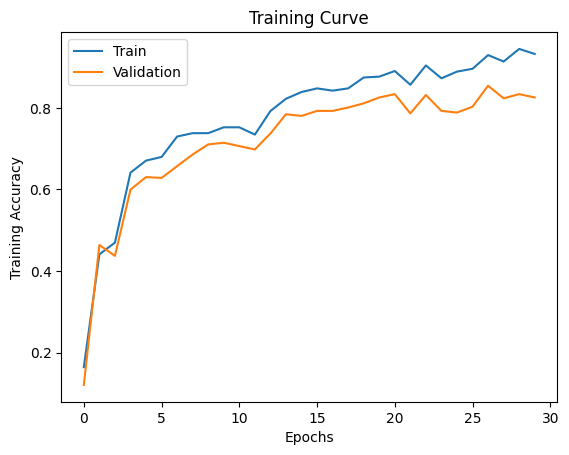

Final Training Accuracy: 0.9320987654320988
Final Validation Accuracy: 0.8254620123203286


In [16]:
model = CNN_Gestures()
train_cnn(model, '0', train_data, lr=0.002, batch_size=100, epochs=30, validation=True, val_data=val_data)

In [17]:
test_loader = loader(test_data, batch_size=100)
print(f'The test accuracy of my model is {get_accuracy(model,test_loader)}')

The test accuracy of my model is 0.8189300411522634
